# Flight Delay Prediction
Predict airline delays for Tunisian aviation company, Tunisair

## Description

Flight delays not only irritate air passengers and disrupt their schedules but also cause :

* a decrease in efficiency
* an increase in capital costs, reallocation of flight crews and aircraft
* an additional crew expenses

As a result, on an aggregate basis, an airline's record of flight delays may have a negative impact on passenger demand.

This solution proposes to build a flight delay predictive model using Machine Learning techniques. The accurate prediction of flight delays will help all players in the air travel ecosystem to set up effective action plans to reduce the impact of the delays and avoid loss of time, capital and resources.



## Business Understanding

#### About the stakeholder: Tunisair

Tunisair is the flag carrier airline of Tunisia. Formed in 1948, it operates scheduled international services to four continents. Its main base is Tunis–Carthage International Airport. The airline's head office is in Tunis, near Tunis Airport. Tunisair is a member of the Arab Air Carriers Organization

<img src="images/Tunisair_plane.jpeg" height=350 />

#### __train/test data__

| **Column Names**  |                                                                                                                                                                                          **Description** |
| ----------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------: |
| ID                |                                                                                                                                                                            id of record                  |
| DATOP          |                                                                                                                                                                                  Date of flight |
| FLTID        |                                                                                                                                                                                     Id of flight ( like id of bus line ) |
| DEPSTN    |                                                                                                                                                                                       Departure point |
| ARRSTN   |                                                                                                                             Arrival point |
| STD|                                                                                                                                                      Scheduled Time departure |
| STA |
| STATUS |
| AC        |                                                                                                                                                              Aircraft Code |
| target   (only in train_data)           |                                                                                                                                  Flight Delay ( in minutes ) |

#### __Airport data__

| **Column Names**  |                                                                                                                                                                                          **Description** |
| ----------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------: |
| icao               |                                                                                                                                                                            The International Civil Aviation Organization or ICAO is a specialized and funding agency of the United Nations, tasked with the planning and development of safe international air transport.                  |
| iata          |                                                                                                                                                                                  IATA code assigned to the airport by IATA consists of 3 letters and created through the airport and city names |
| name        |                                                                                                                                                                                     Airport name |
| city    |                                                                                                                                                                                       City where the airport is located |
| subd   |                                                                                                                             Subdivision (e.g. state, province, region, etc.) |
| country|                                                                                                                                                      Country in which the airport is located|
| elevation |                                                                                                                                                               MSL elevation (the highest point of the landing area) in feet|
| lat |                                                                                                                                                                             Latitude (decimal)|
| lon       |                                                                                                                                                              Longitude (decimal) |
| tz             |                                                                                                                                  Timezone of the airport |

## Setting up Problem

Lets set some background first:

Customer browsing through some flight booking website and want to book flight for some specific date, time, source and destination.

__IDEA:__ If during flight booking, we can show to customer whether the flight he/she considering for booking is likely to arrive on time or not. Additionaly, if flight is expected to delay, also show delayed time.

If customer know that the flight is likely to be late, he/she might choose to book another flight.

From Modelling Propective, need to set two goals:

__GOAL I:__ Predict whether flight is going to delay or not.
<br>

__GOAL II:__ If flight delays, predict amount of time by which it delays.

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go
import warnings
warnings.filterwarnings('ignore')

# Import airport data
import airportsdata
airports = airportsdata.load()

# Import scripts
from script_files.feature_engineering import *
from script_files.prepare_flight_data import *


In [2]:
# Loading the data in and Shape to fit
airports = pd.DataFrame(airports).T.reset_index(drop=True)
# test data
train_df = pd.read_csv("data/Train.csv")
# train data
test_df = pd.read_csv("data/Test.csv")

# Print all of them for overview
print("==="*40)
print('\033[1m'+"Airport data"+ '\033[0m')
display(airports.head())
print()
print("==="*40)
print('\033[1m'+"Training data"+ '\033[0m')
display(train_df.head())
print()
print("==="*40)
print('\033[1m'+"Test data"+ '\033[0m')
display(test_df.head())

Airport data


,icao,iata,name,city,subd,country,elevation,lat,lon,tz
0,00AK,,Lowell Field,Anchor Point,Alaska,US,450.0,59.9492,-151.695999,America/Anchorage
1,00AL,,Epps Airpark,Harvest,Alabama,US,820.0,34.864799,-86.770302,America/Chicago
2,00AZ,,Cordes Airport,Cordes,Arizona,US,3810.0,34.305599,-112.165001,America/Phoenix
3,00CA,,Goldstone /Gts/ Airport,Barstow,California,US,3038.0,35.350498,-116.888,America/Los_Angeles
4,00CO,,Cass Field,Briggsdale,Colorado,US,4830.0,40.6222,-104.344002,America/Denver



Training data


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0



Test data


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC
0,test_id_0,2016-05-04,TU 0700,DJE,TUN,2016-05-04 06:40:00,2016-05-04 07.30.00,ATA,TU 32AIMF
1,test_id_1,2016-05-05,TU 0395,TUN,BKO,2016-05-05 15:20:00,2016-05-05 20.05.00,ATA,TU 320IMW
2,test_id_2,2016-05-06,TU 0745,FRA,TUN,2016-05-06 10:00:00,2016-05-06 12.25.00,ATA,TU 32AIMC
3,test_id_3,2016-05-11,TU 0848,BEY,TUN,2016-05-11 09:40:00,2016-05-11 13.10.00,ATA,TU 31BIMO
4,test_id_4,2016-05-11,TU 0635,ORY,MIR,2016-05-11 09:50:00,2016-05-11 12.35.00,ATA,TU 736IOQ


## Understand the Data

1. How many flights are in our data set, in which date period we have data?
2. What datatype are in the data?
3. Are there any missing values?
4. Which features are continuous or categorical?
5. Are there any Outliers?

__1. How many flights are in our data set, in which date period we have data?__

In [3]:
print(train_df["DATOP"].min())
print(train_df["DATOP"].max())

2016-01-01
2018-12-31


Dates of flights from 2016-01-01 till 2018-12-31

In [4]:
# Getting an idea of the dimension
print('Number of rows in the flightdata dataset : ',train_df.shape[0])
print('Number of columns in the flightdata dataset : ',train_df.shape[1])

Number of rows in the flightdata dataset :  107833
Number of columns in the flightdata dataset :  10


We can observe that the data set contain 107833 rows and 10 columns.

__2. What datatype are in the data?__

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


**Data-types**  
- The dataset contains 9 columns with objects (text) and the target variable is a float type. <br>

- We expect that all information about the date will be given as datatime type.

__3. Are there any missing values?__

In [6]:
# import from script files folder feature engineering script
missing_values_table(train_df)

Your selected dataframe has 10 columns and 107833 Rows.
There are 0 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero and Missing Values,Data Type


As we can see we have no missing data

__4. Which features are continuous or categorical__

In [7]:
# All continuous variables
train_df.select_dtypes("object").columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC'],
      dtype='object')

__5. Are there any Outliers__

In [8]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
target,107833.0,48.733013,117.135562,0.0,0.0,14.0,43.0,3451.0


The maxinum and minimum duration of flight delay is 3451 minutes and 0 minutes respectively

## Data Preparing

Prepare the data for further processing of the data

In [9]:
# Berlin Schönefeld is referenced as SXF in the data, but only exists as BER in the airports data. Therefore we replace SXF with BER. from the prepare flights script
train_df = fix_airport(train_df)
test_df = fix_airport(test_df)

In [10]:
# Merge airportsdata function from the prepare flights script
train_airport_df = merge_airports(train_df,airports)
test_airport_df = merge_airports(test_df,airports)

In [11]:
train_airport_df.head()

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,icao_ARR,iata_ARR,name_ARR,city_ARR,subd_ARR,country_ARR,elevation_ARR,lat_ARR,lon_ARR,tz_ARR
0,train_id_15674,2016-01-01,TU 0564,NKC,TUN,2016-01-01 00:15:00,2016-01-01 04.30.00,ATA,TU 320IMV,0.0,...,DTTA,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851002,10.2272,Africa/Tunis
1,train_id_15676,2016-01-01,TU 0714,JED,TUN,2016-01-01 00:55:00,2016-01-01 05.30.00,ATA,TU 332IFM,195.0,...,DTTA,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851002,10.2272,Africa/Tunis
2,train_id_15675,2016-01-01,TU 0614,DKR,TUN,2016-01-01 01:20:00,2016-01-01 05.55.00,ATA,TU 320IMU,49.0,...,DTTA,TUN,Tunis Carthage International Airport,Tunis,Tunis,TN,22.0,36.851002,10.2272,Africa/Tunis
3,train_id_30980,2016-01-01,UG 0002,TUN,DJE,2016-01-01 06:15:00,2016-01-01 07.15.00,SCH,UG AT7LBD,0.0,...,DTTJ,DJE,Djerba Zarzis International Airport,Djerba,Madanin,TN,19.0,33.875,10.7755,Africa/Tunis
4,train_id_7179,2016-01-01,TU 0880,TUN,AMS,2016-01-01 06:30:00,2016-01-01 09.20.00,ATA,TU 736IOP,36.0,...,EHAM,AMS,Amsterdam Airport Schiphol,Amsterdam,North Holland,NL,-11.0,52.308601,4.76389,Europe/Amsterdam


In [12]:
# All columns that we had now
train_airport_df.columns

Index(['ID', 'DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'target', 'icao_DEP', 'iata_DEP', 'name_DEP', 'city_DEP',
       'subd_DEP', 'country_DEP', 'elevation_DEP', 'lat_DEP', 'lon_DEP',
       'tz_DEP', 'icao_ARR', 'iata_ARR', 'name_ARR', 'city_ARR', 'subd_ARR',
       'country_ARR', 'elevation_ARR', 'lat_ARR', 'lon_ARR', 'tz_ARR'],
      dtype='object')

In [13]:
# Rename the columns for a better understanding
# train_airport_df.columns=['id','flight_date','flight_number','departure_point','arrival_point','scheduled_time_departure','scheduled_time_arrival','flight_status','aircraft_code',"target"]
# test_airport_df.columns=['id','flight_date','flight_number','departure_point','arrival_point','scheduled_time_departure','scheduled_time_arrival','flight_status','aircraft_code',"target"]

## Create Features

In [14]:
# create all featrues for firstly more insights
train_airport_df = create_feature(train_airport_df)
train_airport_df = lat_lon_distance(train_airport_df)

In [15]:
# Calculate the flight distance from the latitude and longitude data
train_airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 107833 non-null  object        
 1   DATOP              107833 non-null  datetime64[ns]
 2   FLTID              107833 non-null  object        
 3   DEPSTN             107833 non-null  object        
 4   ARRSTN             107833 non-null  object        
 5   STD                107833 non-null  datetime64[ns]
 6   STA                107833 non-null  datetime64[ns]
 7   STATUS             107833 non-null  object        
 8   AC                 107833 non-null  object        
 9   target             107833 non-null  float64       
 10  icao_DEP           107833 non-null  object        
 11  iata_DEP           107833 non-null  object        
 12  name_DEP           107833 non-null  object        
 13  city_DEP           107833 non-null  object  

## Exploratory Data Analysis

### Hyptotheses
Why are the flights late?

1. More international flights than domestic flights are affected by delays
2. The season, day of the week and time of day plays a role in the delay
3. Are the delays due to the Individual aircraft

##### Quick Overview

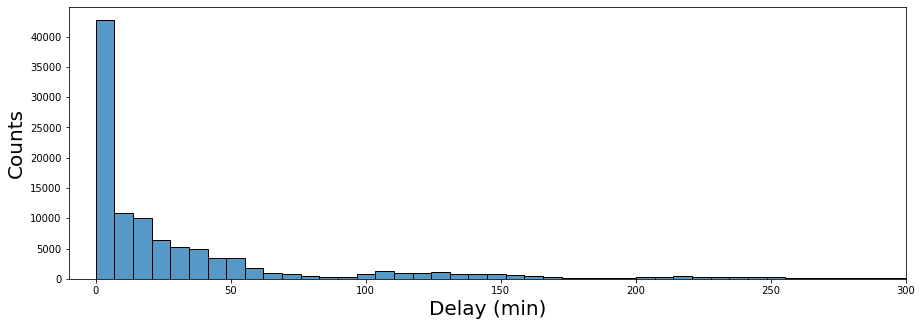

In [16]:
# Histplot to see the distribution of delays
fig, ax = plt.subplots(figsize=(15,5))
sns.histplot(train_airport_df.target, bins=500,edgecolor="black", 
             linewidth=1)
plt.xlim(-10, 300)
plt.xlabel("Delay (min)", fontsize=20)
plt.ylabel("Counts", fontsize=20);

Here is an overview of the time distribution of delays as we can see most flights are delayed less than one hour

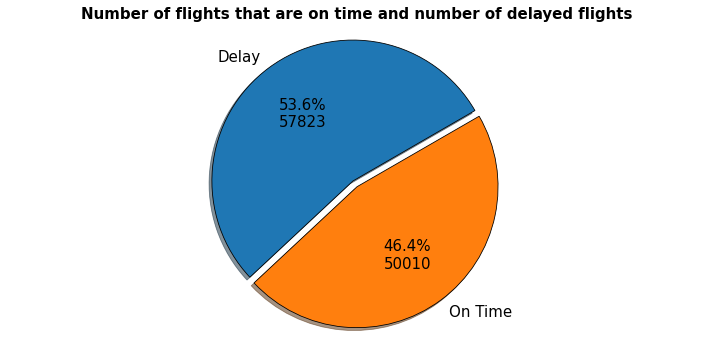

In [17]:
# grouped dataframe to plot the number of flights on time and on delay
on_time = train_airport_df.groupby(["delay_or_onTime"]).size().to_frame("count").reset_index()
# Pie chart style and size
plt.figure(figsize=(10,5))
explode = [0,0.05]

# function to get the % Values as the counted values
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n{:d}".format(pct, absolute)

#create the pie charts
plt.pie(on_time["count"], labels=["Delay","On Time"],
        shadow=True, startangle=30,
        textprops=dict(color="black",size=15),explode=explode,autopct=lambda pct: func(pct, on_time["count"]),
        wedgeprops = { 'linewidth' : 0.8,'edgecolor' : "black" })
plt.axis('equal')
plt.title("Number of flights that are on time and number of delayed flights",fontweight="bold",fontsize=15)
plt.tight_layout();

Of our 107833 flights, 50010 (46.37%) are on time and 57823 (53.62%) are delayed. 

#### __1. More international flights than domestic flights are affected by delays__

In [18]:
train_plot = train_airport_df.groupby(["DEPSTN","lat_DEP","lon_DEP","name_DEP","country_DEP"]).median().reset_index()

# Plot a map with the median delay of all Departure airports

fig = px.scatter_mapbox(train_plot, lat="lat_DEP", lon="lon_DEP", color="target", size="target", 
                        hover_data={'lat_DEP':False, 'lon_DEP':False, 'target':True, 'DEPSTN':True,"country_DEP":True},
                        hover_name="name_DEP",
                        zoom=1.7,
                        height=500,
                        width=800,
                        center={'lat':30, 'lon':-10},
                        title='Median delay per airport',
                        labels={'target': 'Delay (min)'},color_continuous_scale="inferno",
                        )
fig.update_layout(mapbox_style="open-street-map",
                    margin={'r':0, 't':30, 'l':0, 'b':0},
                    title_font_size= 23,uniformtext_minsize=8, uniformtext_mode='hide'
                    )
fig.show()

The airports with the largest departure delays are Volgograd International Airport in Russia, Rotterdam Airport in the Netherlands and Boryspil International Airport in Ukraine.

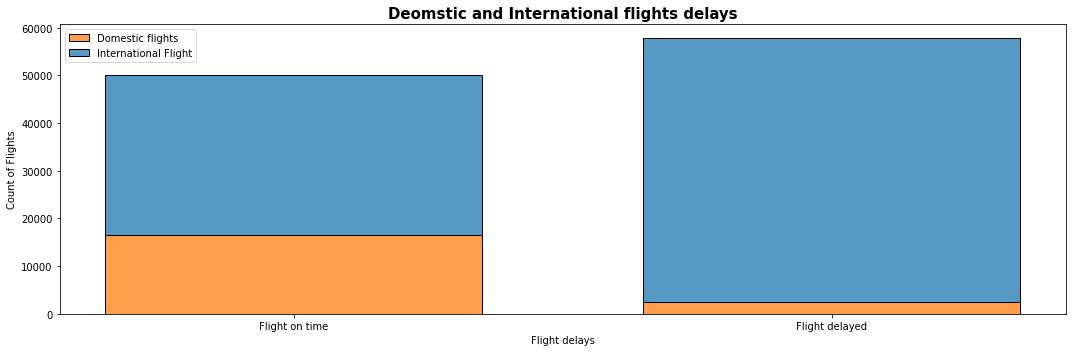

In [19]:
# count plot on two categorical variable
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.histplot(x="delay_or_onTime", hue="domestic", data=train_airport_df, stat="count", multiple="stack"
             ,shrink = 0.7, ax=ax,edgecolor="black", 
             linewidth=1)
ax.set_ylabel('Count of Flights')
ax.set_xlabel('Flight delays')
ax.set_xticklabels(["Flight on time","Flight delayed"])
ax.legend(["Domestic flights","International Flight"]);


plt.title("Deomstic and International flights delays",fontweight="bold",fontsize=15)
plt.tight_layout()


* From flights on-time, 16456 (32.90%) are domestic flights and 33554 (67.09%) are international flights. 
* And the delayed flights, 2445 (4.22%) domestic flights and incredible 55378 (95.77%) international flights are delayed.

In [20]:
# for the calculation above
df_calc_text = train_airport_df.groupby(["delay_or_onTime","domestic"]).count().reset_index()

#### __2. The season, day of the week and time of day plays a role in the delay__

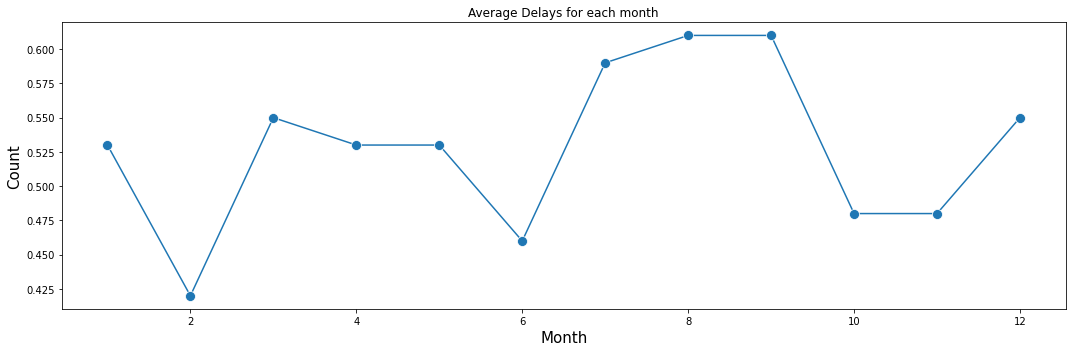

In [21]:
months_mean = train_airport_df.groupby('flight_month').mean().reset_index().round(2)
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.lineplot(x="flight_month",y ='delayed', data=months_mean, marker="o",markersize=10)
ax.set_xlabel("Month",fontsize=15)
ax.set_ylabel("Count",fontsize=15)
ax.set_title("Average Delays for each month")

plt.tight_layout()

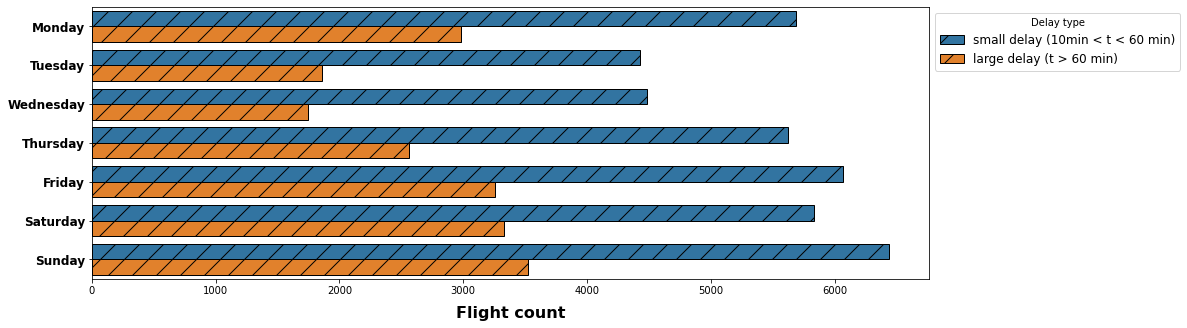

In [22]:
df_delay = pd.DataFrame(train_airport_df.query("delay_or_onTime == 'delay'").value_counts().reset_index())
# Sorting thr days
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

from pandas.api.types import CategoricalDtype
cat_type = CategoricalDtype(categories=cats, ordered=True)
df_delay["dep_weekday"] = df_delay["dep_weekday"].astype(cat_type)

# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 10],2)[x > 60]
df_delay['DELAY_LEVEL'] = df_delay['target'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(15,5))
ax = sns.countplot(y="dep_weekday", hue='DELAY_LEVEL', data=df_delay,edgecolor="black", 
             linewidth=1,hatch="/")

plt.setp(ax.get_xticklabels(), fontsize=10, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend(title="Delay type",fontsize = 'large', title_fontsize = "10",loc = 2, bbox_to_anchor = (1,1))
L.get_texts()[0].set_text('small delay (10min < t < 60 min)')
L.get_texts()[1].set_text('large delay (t > 60 min)')
plt.show()

Just at the weekend the flights are just delayed and to the beginning of the week

### __3. Are the delays due to the Individual aircraft__

In [23]:
train_airport_df

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target,...,delayed,domestic,dep_hour,dep_weekday,duration_min,arr_hour,flight_month,flight_month_name,year,distance
0,train_id_15674,2016-01-01,TU 0564,NKC,TUN,2016-01-01 00:15:00,2016-01-01 04:30:00,ATA,TU 320IMV,0.0,...,0,0,0,Friday,255.0,4,1,January,2016,3298.067996
1,train_id_15676,2016-01-01,TU 0714,JED,TUN,2016-01-01 00:55:00,2016-01-01 05:30:00,ATA,TU 332IFM,195.0,...,1,0,0,Friday,275.0,5,1,January,2016,3256.052105
2,train_id_15675,2016-01-01,TU 0614,DKR,TUN,2016-01-01 01:20:00,2016-01-01 05:55:00,ATA,TU 320IMU,49.0,...,1,0,1,Friday,275.0,5,1,January,2016,3678.974557
3,train_id_30980,2016-01-01,UG 0002,TUN,DJE,2016-01-01 06:15:00,2016-01-01 07:15:00,SCH,UG AT7LBD,0.0,...,0,1,6,Friday,60.0,7,1,January,2016,333.916459
4,train_id_7179,2016-01-01,TU 0880,TUN,AMS,2016-01-01 06:30:00,2016-01-01 09:20:00,ATA,TU 736IOP,36.0,...,1,0,6,Friday,170.0,9,1,January,2016,1770.371959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107828,train_id_107818,2018-12-31,WKL 0000,TUN,TUN,2018-12-31 22:00:00,2019-01-01 01:00:00,SCH,TU 32AIMF,0.0,...,0,1,22,Monday,180.0,1,12,December,2018,0.000000
107829,train_id_107776,2018-12-31,WKL 0000,MIR,MIR,2018-12-31 22:00:00,2019-01-01 01:00:00,SCH,TU 736IOM,0.0,...,0,1,22,Monday,180.0,1,12,December,2018,0.000000
107830,train_id_103139,2018-12-31,TU 0841,DSS,CKY,2018-12-31 22:20:00,2018-12-31 23:35:00,ATA,TU 320IMU,16.0,...,1,0,22,Monday,75.0,23,12,December,2018,677.428198
107831,train_id_103138,2018-12-31,TU 0399,ABJ,NIM,2018-12-31 22:40:00,2019-01-01 00:35:00,ATA,TU 320IMW,0.0,...,0,0,22,Monday,115.0,0,12,December,2018,1129.691078


In [24]:
list_of_ac = train_airport_df['AC'].unique().tolist()
flights_dict = dict()
ac_group = train_airport_df.groupby('AC')
for x in list_of_ac:
    df_ac = ac_group.get_group(x)
    flights_dict[x] = train_airport_df[train_airport_df['AC'] == x]['year'].value_counts().to_dict()

In [25]:
flights_dict

{'TU 320IMV': {2018: 1610, 2017: 1563, 2016: 1416},
 'TU 332IFM': {2018: 958, 2017: 870, 2016: 666},
 'TU 320IMU': {2018: 1644, 2017: 1602, 2016: 1478},
 'UG AT7LBD': {2016: 1010, 2018: 466, 2017: 456},
 'TU 736IOP': {2017: 1376, 2016: 1065, 2018: 88},
 'TU 32AIML': {2018: 1513, 2017: 1323, 2016: 1286},
 'TU 736IOR': {2018: 1160, 2016: 1104, 2017: 906},
 'TU 32AIMF': {2018: 1441, 2016: 1322, 2017: 1020},
 'TU 736IOK': {2018: 1363, 2016: 1316, 2017: 107},
 'TU 736IOL': {2018: 1198, 2017: 1006, 2016: 847},
 'TU 31BIMQ': {2018: 1490, 2016: 1296, 2017: 1266},
 'TU 32AIMC': {2016: 213, 2017: 1, 2018: 1},
 'TU 31BIMO': {2016: 1265, 2018: 1125, 2017: 525},
 'TU 320IMT': {2017: 1638, 2018: 1554, 2016: 1442},
 'TU 32AIMD': {2018: 1450, 2017: 1273, 2016: 872},
 'TU 320IMS': {2016: 1461, 2017: 1410, 2018: 1343},
 'TU 736IOQ': {2018: 1391, 2017: 1283, 2016: 398},
 'TU 32AIMN': {2018: 1569, 2017: 1264, 2016: 976},
 'TU 320IMR': {2017: 1643, 2018: 1620, 2016: 1338},
 'UG AT7LBE': {2016: 1098, 2017: 

In [26]:
days = train_airport_df.query("delay_or_onTime == 'delay'")['DATOP']
days

delay_miami = train_airport_df.query("delay_or_onTime == 'delay'")['duration_min']

delay_miami

1         275.0
2         275.0
4         170.0
5         165.0
8         125.0
          ...  
107817    135.0
107818    170.0
107820    240.0
107823    265.0
107830     75.0
Name: duration_min, Length: 57823, dtype: float64

In [27]:
train_airport_df.duration_min

0         255.0
1         275.0
2         275.0
3          60.0
4         170.0
          ...  
107828    180.0
107829    180.0
107830     75.0
107831    115.0
107832    280.0
Name: duration_min, Length: 107833, dtype: float64

#### Correlation

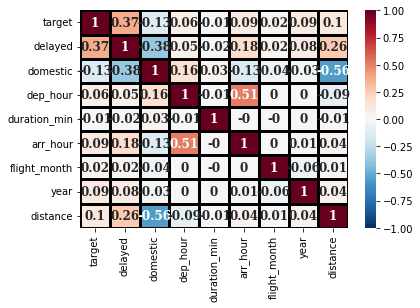

In [28]:
# Heatmap of the Pearson correlation coefficients to see releationships

sns.heatmap(
    round(train_airport_df.corr(), 2),
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
    annot=True,
    linewidths=1.1,
    linecolor="black",
    annot_kws={"fontsize": 12, "fontfamily": "serif", "fontweight": "bold"},
);

### CSV files for modelling

In [ ]:
train_airport_df.to_csv("data/final_train.csv")
test_airport_df.to_csv("data/final_test.csv")
